### Генерируем датасет

In [34]:
from PIL import Image, ImageDraw, ImageShow
import random
import string
import numpy as np

def one_hot(x, length):
    return [1 if x==i else 0 for i in range(length)]

def get_word(c):
    words = ["cat", "eagle", "none"]
    return (words[c], one_hot(c,len(words)))

cell_w = 32
cell_h = 32
grid_w = 2
grid_h = 2

eagle = Image.open("eagle.jpg")
cat = Image.open("cat.jpg")
targetbox = (0,0,20,20)

cat.crop(targetbox).save("cat_1.jpg")
cat_crop = Image.open("./cat_1.jpg")
eagle.crop(targetbox).save("eagle_1.jpg")
eagle_crop = Image.open("./eagle_1.jpg")

In [36]:
for j in range(0,5000):
    img = Image.new('RGB', (grid_w*cell_w,grid_h*cell_h))
    d = ImageDraw.Draw(img)                    

    img.save('Images %d.PNG'% j, 'PNG')
    
    with open('Labels%d.txt'%j,'w+') as f:
     
        for row in range(grid_w):
            for col in range(grid_h):

                (digits, cat) = get_word(random.randint(0,2))

                width = 20
                height = 20
                
                if(digits=='none'):
                    f.write('%d %d %d\n' % (cat[0],cat[1],cat[2]) )        
                    f.write('%d %d %d %d\n' % ( col*cell_w+cell_w/2, row*cell_h+cell_h/2, cell_w, cell_h ))
                    f.write('0\n') # confidence of object
                else:
                    x = random.randrange(col*cell_w, (col+1)*cell_w)
                    y = random.randrange(row*cell_w, min(67, (row+1)*cell_h))                    
                    if digits == "cat":
                        target = cat_crop
                    if digits == "eagle":
                        target = eagle_crop
                    img.paste(target,(x-width//2, y-height//2))
                    f.write('%d %d %d\n' % (cat[0],cat[1],cat[2]))
                    f.write('%d %d %d %d\n' % (x, y, width, height) )
                    f.write('1\n')        
        f.write('---\n')

    img.save('Images %d.PNG'% j, 'PNG')

In [37]:
from __future__ import print_function
import keras
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, Reshape
from keras.layers import Conv2D, MaxPooling2D

from keras.layers.advanced_activations import LeakyReLU, PReLU

from keras import backend as K
from keras.models import load_model
import numpy as np
import sys
import cv2
import argparse

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import matplotlib.pyplot as plt
import matplotlib.patches as patches
tf.compat.v1.disable_v2_behavior()

In [38]:
x_train = []
y_train = []

nb_boxes=1
grid_w=2
grid_h=2
cell_w=32
cell_h=32
img_w=grid_w*cell_w
img_h=grid_h*cell_h

In [39]:
def load_image(j):
    img = cv2.imread('Images %d.PNG' % j)    
    x_t = img_to_array(img)
    with open("Labels%d.txt" % j, "r") as f:
        y_t = []
        for row in range(grid_w):
            for col in range(grid_h):
                c_t = [float(i) for i in f.readline().split()]
                [x, y, w, h] = [float(i) for i in f.readline().split()]        
                conf_t = [float(i) for i in f.readline().split()]                
                elt = []
                elt += c_t
                for b in range(nb_boxes):
                    elt += [x/cell_w, y/cell_h, w/img_w, h/img_h] + conf_t
                y_t.append(elt)
        assert(f.readline()=="---\n")
        
    return [x_t, y_t]

Загружаем все изображения и добавляем в вектор

In [40]:
for j in range(10, 5000):
    [x,y] = load_image(j)
    x_train.append(x)
    y_train.append(y)

x_train = np.array(x_train)
y_train = np.array(y_train)

Нейронная сеть

In [41]:
i = Input(shape=(img_h,img_w,3))
x = Conv2D(16, (1, 1))(i)
x = Conv2D(32, (3, 3))(x)
x = keras.layers.LeakyReLU(alpha=0.3)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(16, (3, 3))(x)
x = Conv2D(32, (3, 3))(x)
x = keras.layers.LeakyReLU(alpha=0.3)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
#x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(256, activation='sigmoid')(x)
x = Dense(grid_w*grid_h*(3+nb_boxes*5), activation='sigmoid')(x)
x = Reshape((grid_w*grid_h,(3+nb_boxes*5)))(x)

model = Model(i, x)

In [42]:
def custom_loss(y_true, y_pred):    
    grid = np.array([ [[float(x),float(y)]]*nb_boxes   for y in range(grid_h) for x in range(grid_w)])
    y_true_class = y_true[...,0:2]
    y_pred_class = y_pred[...,0:2] 

    pred_boxes = K.reshape(y_pred[...,3:], (-1,grid_w*grid_h,nb_boxes,5))
    true_boxes = K.reshape(y_true[...,3:], (-1,grid_w*grid_h,nb_boxes,5))
    
    y_pred_xy   = pred_boxes[...,0:2] + K.variable(grid)
    # w and h predicted are 0 to 1 with 1 being image size
    y_pred_wh   = pred_boxes[...,2:4]
    # probability that there is something to predict here
    y_pred_conf = pred_boxes[...,4]

    # same as predicate except that we don't need to add an offset, coordinate are already between 0 and cell count
    y_true_xy   = true_boxes[...,0:2]
    # with and height
    y_true_wh   = true_boxes[...,2:4]
    # probability that there is something in that cell. 0 or 1 here as it's a certitude.
    y_true_conf = true_boxes[...,4]

    clss_loss  = K.sum(K.square(y_true_class - y_pred_class), axis=-1)
    xy_loss    = K.sum(K.sum(K.square(y_true_xy - y_pred_xy),axis=-1)*y_true_conf, axis=-1)
    wh_loss    = K.sum(K.sum(K.square(K.sqrt(y_true_wh) - K.sqrt(y_pred_wh)), axis=-1)*y_true_conf, axis=-1)

    # when we add the confidence the box prediction lower in quality but we gain the estimation of the quality of the box
    # however the training is a bit unstable

    # compute the intersection of all boxes at once (the IOU)
    intersect_wh = K.maximum(K.zeros_like(y_pred_wh), (y_pred_wh + y_true_wh)/2 - K.square(y_pred_xy - y_true_xy) )
    intersect_area = intersect_wh[...,0] * intersect_wh[...,1]
    true_area = y_true_wh[...,0] * y_true_wh[...,1]
    pred_area = y_pred_wh[...,0] * y_pred_wh[...,1]
    union_area = pred_area + true_area - intersect_area
    iou = intersect_area / union_area

    conf_loss = K.sum(K.square(y_true_conf*iou - y_pred_conf), axis=-1)

    # final loss function
    d = xy_loss + wh_loss + conf_loss + clss_loss
    
    if False:
        d = tf.Print(d, [d], "loss")
        d = tf.Print(d, [xy_loss], "xy_loss")
        d = tf.Print(d, [wh_loss], "wh_loss")
        d = tf.Print(d, [clss_loss], "clss_loss")
        d = tf.Print(d, [conf_loss], "conf_loss")
    
    return d

In [43]:
model = Model(i, x)

adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss=custom_loss, optimizer=adam) # better

print(model.summary())

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 16)        64        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 62, 62, 32)        4640      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 29, 29, 16)        4624      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 27, 27, 32)        4640

In [44]:
model.fit(x_train, y_train, batch_size=64, epochs=25)

Epoch 1/25
4990/4990 [==============================] - 15s 3ms/step - loss: 0.5432
Epoch 2/25
4990/4990 [==============================] - 14s 3ms/step - loss: 0.3096
Epoch 3/25
4990/4990 [==============================] - 14s 3ms/step - loss: 0.2157
Epoch 4/25
4990/4990 [==============================] - 14s 3ms/step - loss: 0.1705
Epoch 5/25
4990/4990 [==============================] - 14s 3ms/step - loss: 0.1370
Epoch 6/25
4990/4990 [==============================] - 14s 3ms/step - loss: 0.1120
Epoch 7/25
4990/4990 [==============================] - 14s 3ms/step - loss: 0.0936
Epoch 8/25
4990/4990 [==============================] - 14s 3ms/step - loss: 0.0797
Epoch 9/25
4990/4990 [==============================] - 14s 3ms/step - loss: 0.0696
Epoch 10/25
4990/4990 [==============================] - 14s 3ms/step - loss: 0.0622
Epoch 11/25
4990/4990 [==============================] - 15s 3ms/step - loss: 0.0565
Epoch 12/25
4990/4990 [==============================] - 14s 3ms/step - lo

C:\Users\Artem\anaconda3\envs\For Data\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


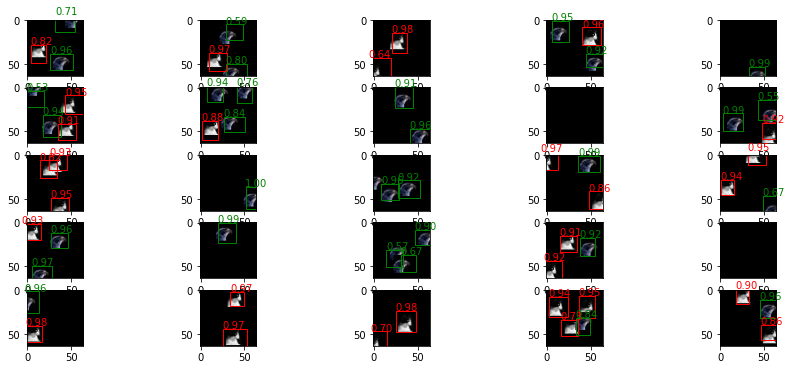

In [48]:
plt.figure(figsize = (15,6))
for j in range(0,25):
    im = load_image(j)
    img = cv2.imread('Images %d.PNG' % j)
    P = model.predict(np.array([ img_to_array(img) ]))
    col = 0
    for row in range(grid_w):
        for col in range(grid_h):
            p = P[0][col*grid_h+row]

            boxes = p[3:].reshape(nb_boxes,5)
            clss = np.argmax(p[0:2])
            ax = plt.subplot(5,5,j+1)
            imgplot = plt.imshow(img)

            i = 0
            for b in boxes:
                x = b[0]+float(row)
                y = b[1]+float(col)
                w = b[2]
                h = b[3]
                conf = b[4]
                if conf < 0.5:
                    continue

                color = ['r','g','b','0'][clss]
                rect = patches.Rectangle((x*cell_w-w/2*img_w, y*cell_h-h/2*img_h), w*img_h, h*img_h, linewidth=1,edgecolor=color,facecolor='none')
                ax.add_patch(rect)

                ax.text( (x*cell_w-w/2*img_w) / img_w, 1-(y*cell_h-h/2*img_h)/img_h-i*0.15, "%0.2f" % (conf), transform=ax.transAxes, color=color)
                i+=1
plt.show()

### Тестовые данные

In [56]:
for j in range(0,2):
    img = Image.new('RGB', (grid_w*cell_w,grid_h*cell_h))
    d = ImageDraw.Draw(img)
    for row in range(grid_w):
            for col in range(grid_h):
                (digits, cat) = get_word(random.randint(0,2))
                width = 20
                height = 20     
                if(digits!='none'):
                    x = random.randrange(col*cell_w, (col+1)*cell_w)
                    y = random.randrange(row*cell_w, min(67, (row+1)*cell_h))                    
                    if digits == "cat":
                        target = cat_crop
                    if digits == "eagle":
                        target = eagle_crop
                    img.paste(target,(x-width//2, y-height//2))
                if j==0:
                    img.save('test1.PNG')
                else:
                    img.save('test2.PNG')

C:\Users\Artem\anaconda3\envs\For Data\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


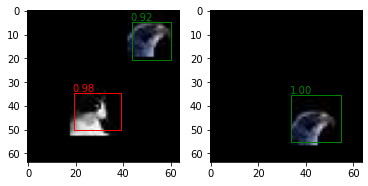

In [57]:
count = 0
for im in ['test1.png', 'test2.png']:
    count=count+1
    img = cv2.imread(im)
    P = model.predict(np.array([ img_to_array(img) ]))

    col = 0
    for row in range(grid_w):
        for col in range(grid_h):
            p = P[0][col*grid_h+row]

            boxes = p[3:].reshape(nb_boxes,5)
            clss = np.argmax(p[0:2])
            
            ax = plt.subplot(1,2,count)
            imgplot = plt.imshow(img)

            i = 0
            for b in boxes:
                x = b[0]+float(row)
                y = b[1]+float(col)
                w = b[2]
                h = b[3]
                conf = b[4]
                if conf < 0.5:
                    continue

                color = ['r','g','b','0'][clss]
                rect = patches.Rectangle((x*cell_w-w/2*img_w, y*cell_h-h/2*img_h), w*img_h, h*img_h, linewidth=1,edgecolor=color,facecolor='none')
                ax.add_patch(rect)

                ax.text( (x*cell_w-w/2*img_w) / img_w, 1-(y*cell_h-h/2*img_h)/img_h-i*0.15, "%0.2f" % (conf), transform=ax.transAxes, color=color)
                i+=1

plt.show()